# FINAL PROJECT: tourism in Europe

In [44]:
# Import libraries

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import folium
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

## Machine Learning: Clustering

In [3]:
# Load the dataset

df = pd.read_csv("../data/clean/airbnb_clean.csv")

In [22]:
# Filter = Paris

df_paris = df[df["city"] == "Paris"].copy()

print(df_paris.shape)
print(df_paris.head())

(53963, 17)
                                     listing_name neighbourhood_cleansed  \
0                                    zen and calm           Observatoire   
1    Your perfect Paris studio on Île Saint-Louis         Hôtel-de-Ville   
2                 MARAIS - 2ROOMS APT - 24 PEOPLE         Hôtel-de-Ville   
3  Cozy, Central Paris WALK or VELIB EVERYWHERE !                 Louvre   
4        room in an artists flat with great view!      Buttes-Montmartre   

   latitude  longitude        room_type  accommodates  bedrooms  beds  \
0  48.83191    2.31870  Entire home/apt             2       1.0   1.0   
1  48.85247    2.35835  Entire home/apt             2       0.0   1.0   
2  48.85909    2.35315  Entire home/apt             4       2.0   1.0   
3  48.86006    2.34863  Entire home/apt             1       1.0   1.0   
4  48.88946    2.35867     Private room             1       1.0   1.0   

   bathrooms bathrooms_text  price  minimum_nights  maximum_nights  \
0        1.0         1

In [26]:
# Keep relevant columns

df_geo = df_paris[["latitude", "longitude", "price"]].dropna()

print(df_geo.describe())

           latitude     longitude         price
count  53963.000000  53963.000000  53963.000000
mean      48.863842      2.341130    285.263384
std        0.017629      0.034145    688.616441
min       48.815890      2.229896      8.000000
25%       48.851110      2.318840    104.000000
50%       48.865070      2.345401    161.000000
75%       48.877650      2.364826    277.000000
max       48.901590      2.468360  30814.000000


In [30]:
# Remove extreme prices (keep only listings under 1000€)

df_geo = df_geo[df_geo["price"] < 1000]
print(df_geo.describe())

           latitude     longitude         price
count  52445.000000  52445.000000  52445.000000
mean      48.863851      2.341636    211.815654
std        0.017724      0.034073    164.266564
min       48.815890      2.229896      8.000000
25%       48.850987      2.319620    102.000000
50%       48.865077      2.345853    157.000000
75%       48.877811      2.365285    262.000000
max       48.901590      2.468360    999.000000


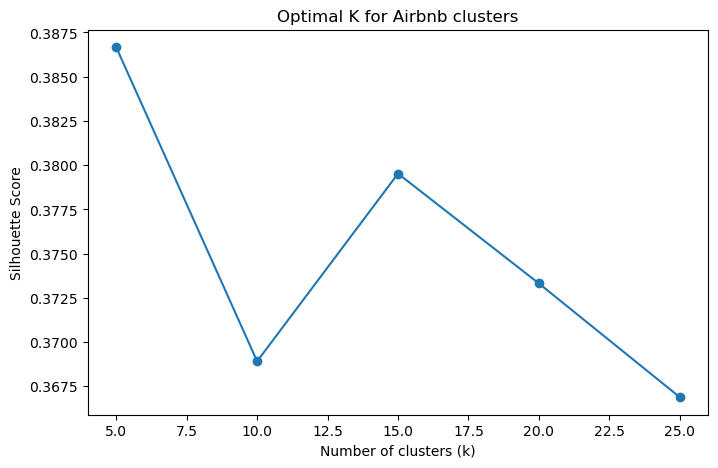

[(5, 0.38666435034313285), (10, 0.36891665197897205), (15, 0.3795221146834881), (20, 0.37331422239297946), (25, 0.36688704284720225)]


In [32]:
scores = []
K_range = range(5, 30, 5)  # test k = 5, 10, 15, 20, 25

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_geo[["latitude", "longitude"]])
    score = silhouette_score(df_geo[["latitude", "longitude"]], labels)
    scores.append(score)

# Visualisation des résultats
plt.figure(figsize=(8,5))
plt.plot(K_range, scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Optimal K for Airbnb clusters")
plt.show()

print(list(zip(K_range, scores)))

In [34]:
# K-means with 5 clusters
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_paris["cluster"] = kmeans.fit_predict(df_paris[["latitude", "longitude"]])

# Center of clusters
centers = kmeans.cluster_centers_
print("Cluster centers:", centers)

Cluster centers: [[48.85725004  2.28998446]
 [48.86096823  2.38755898]
 [48.86888812  2.35816079]
 [48.84102118  2.33755077]
 [48.88345659  2.33282048]]


In [46]:
# Central point in Paris to initialize the map
paris_center = [48.8566, 2.3522]
m = folium.Map(location=paris_center, zoom_start=12)

# Add the dwellings with a color according to their cluster
colors = ["red", "blue", "green", "purple", "orange"]

for idx, row in df_paris.sample(2000, random_state=42).iterrows():  
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color=colors[row["cluster"]],
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

# Add centers of clusters
for i, center in enumerate(centers):
    avg_price = cluster_stats.loc[i, "price"]
    count = cluster_stats.loc[i, "count_listings"]

    folium.Marker(
        location=[center[0], center[1]],
        popup=f"Cluster {i}: {count} listings, Avg price: {avg_price:.2f} €",
        icon=folium.Icon(color="black", icon="info-sign")
    ).add_to(m)

m

In [38]:
cluster_stats = df_paris.groupby("cluster").agg({
    "price": "mean",
    "accommodates": "mean",
    "latitude": "count"
}).rename(columns={"latitude": "count_listings"})

print(cluster_stats)

              price  accommodates  count_listings
cluster                                          
0        373.486417      3.522847           11227
1        204.467062      3.254569            9958
2        284.102253      3.462405           13672
3        279.433599      3.335737            8042
4        274.132502      3.282809           11064


## Machine Learning: regression - Prediction price

In [65]:
# Encode categorical variables
df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, columns=["room_type", "city"], drop_first=True)

# Features and target
X = df_encoded[['accommodates', 'bedrooms', 'beds',
                'availability_365', 'number_of_reviews'] +
               [col for col in df_encoded.columns if col.startswith("room_type_") or col.startswith("city_")]]

y = df_encoded["price"]

In [67]:
# Remove rows with missing values in X or y
X = X.dropna()
y = y.loc[X.index]  # keep same indices

In [69]:
# Trains/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [73]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [75]:
# Evaluation
print("Model Evaluation Results")

# Linear Regression
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)
print(f"Linear Regression → RMSE: {rmse_lin:.2f}, R²: {r2_lin:.3f}")

# Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest → RMSE: {rmse_rf:.2f}, R²: {r2_rf:.3f}")

Model Evaluation Results
Linear Regression → RMSE: 770.12, R²: 0.050
Random Forest → RMSE: 773.66, R²: 0.041


### Linear and Random Forest: No performant models

## Machine Learning: XGBoost

In [84]:
# --- XGBoost Regressor ---
xgb = XGBRegressor(
    n_estimators=500,      # nombre d'arbres
    learning_rate=0.05,    # taux d'apprentissage
    max_depth=6,           # profondeur max des arbres
    subsample=0.8,         # échantillonnage
    colsample_bytree=0.8,  # features sampling
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# --- Évaluation ---
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost → RMSE:", round(rmse_xgb, 2), ", R²:", round(r2_xgb, 3))

XGBoost → RMSE: 732.56 , R²: 0.141


In [6]:
# --- 1. Créer prix par personne ---
df["price_per_person"] = df["price"] / df["accommodates"]

# Retirer les valeurs extrêmes (max 500€/pers/nuit pour limiter outliers)
df = df[df["price_per_person"] < 500]

In [8]:
# --- 2. Catégoriser prix ---
bins = [0, 50, 150, 500]  
labels = ["cheap", "mid_range", "luxury"]

df["price_class"] = pd.cut(df["price_per_person"], bins=bins, labels=labels)

print(df["price_class"].value_counts(normalize=True))

price_class
cheap        0.611511
mid_range    0.350718
luxury       0.037771
Name: proportion, dtype: float64


In [32]:
# --- 3. Features et target ---
X = df[['accommodates', 'bedrooms', 'beds',
        'availability_365', 'number_of_reviews'] +
       [col for col in df.columns if col.startswith("room_type_") or col.startswith("city_")]]

y = df["price_class"].dropna()
X = X.loc[y.index]  # garder les mêmes indices

In [34]:
X = X.dropna()
y = y.loc[X.index]  # garder mêmes indices

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [38]:
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # remplace les NaN par la médiane
    ("rf", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42
    ))
])

# Entraînement
rf_pipeline.fit(X_train, y_train)

# Prédictions
y_pred = rf_pipeline.predict(X_test)

# Évaluation
print("RandomForestClassifier - Results")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

RandomForestClassifier - Results
              precision    recall  f1-score   support

       cheap       0.68      0.68      0.68     13839
      luxury       0.14      0.33      0.19       845
   mid_range       0.43      0.37      0.40      7929

    accuracy                           0.56     22613
   macro avg       0.42      0.46      0.42     22613
weighted avg       0.57      0.56      0.56     22613

Confusion Matrix:
 [[9392  863 3584]
 [ 286  280  279]
 [4129  897 2903]]


In [46]:
y_binary = (y == "luxury").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95     21768
           1       0.15      0.36      0.21       845

    accuracy                           0.90     22613
   macro avg       0.56      0.64      0.58     22613
weighted avg       0.94      0.90      0.92     22613



             feature  importance
3   availability_365    0.465526
4  number_of_reviews    0.347073
0       accommodates    0.073463
2               beds    0.058430
1           bedrooms    0.055508


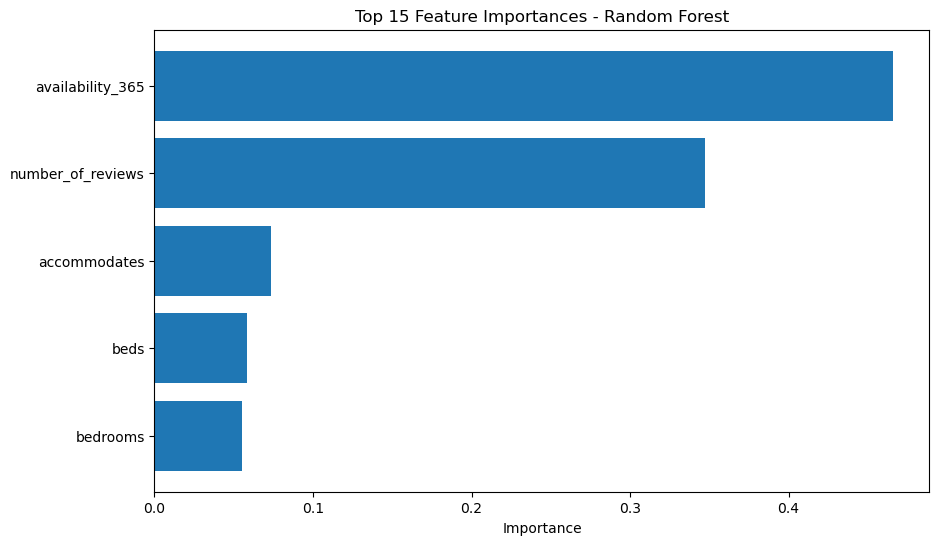

In [48]:
# Récupérer les importances
importances = rf.feature_importances_
features = X_train.columns

# Mettre dans un DataFrame pour trier
feat_importances = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_importances.head(10))

# Visualisation
plt.figure(figsize=(10,6))
plt.barh(feat_importances["feature"][:15], feat_importances["importance"][:15])
plt.gca().invert_yaxis()  # la plus importante en haut
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()